<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первичный-анализ-данных" data-toc-modified-id="Первичный-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первичный анализ данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Моделирование</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Настройка-гиперпараметров" data-toc-modified-id="Настройка-гиперпараметров-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Настройка гиперпараметров</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект: «Прогнозирование заказов такси»

В нашем распоряжении исторические данные таксопарка о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час.

**Цели:**
1. Построить модель предсказания количество заказов такси.
2. Значение метрики RMSE на тестовой выборке должно быть не более 48.

**Описание данных:**
- `num_orders` — число заказов

## Первичный анализ данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

import optuna

%matplotlib inline
sns.set_style("darkgrid")
random_seed = 17

In [3]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
if df.index.is_monotonic:
    print(f'Даты и время расположены в хронологическом порядке')
else:
    df = df.sort_index()
    print(f'Даты и время расположены не в хронологическом порядке. Проведена сортировка')

Даты и время расположены в хронологическом порядке


In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Выводы:**
1. Даты и время расположены в хронологическом порядке.
2. Временной ряд представляет собой последовательность количества заказов такси в диапазоне от *2018-03-01 00:00:00* до *2018-08-31 23:50:00* с интервалом *10 минут*.
2. Необходимо провести ресемплирование временного ряда по одному часу.

## Исследовательский анализ данных

**Необходимо проанализировать:**
1. Вариативность значений количества заказов.
2. Тренд временного ряда.
3. Сезонность временного ряда.
4. Стационарность временного ряда.

In [7]:
df = df.resample('1H').sum()

In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


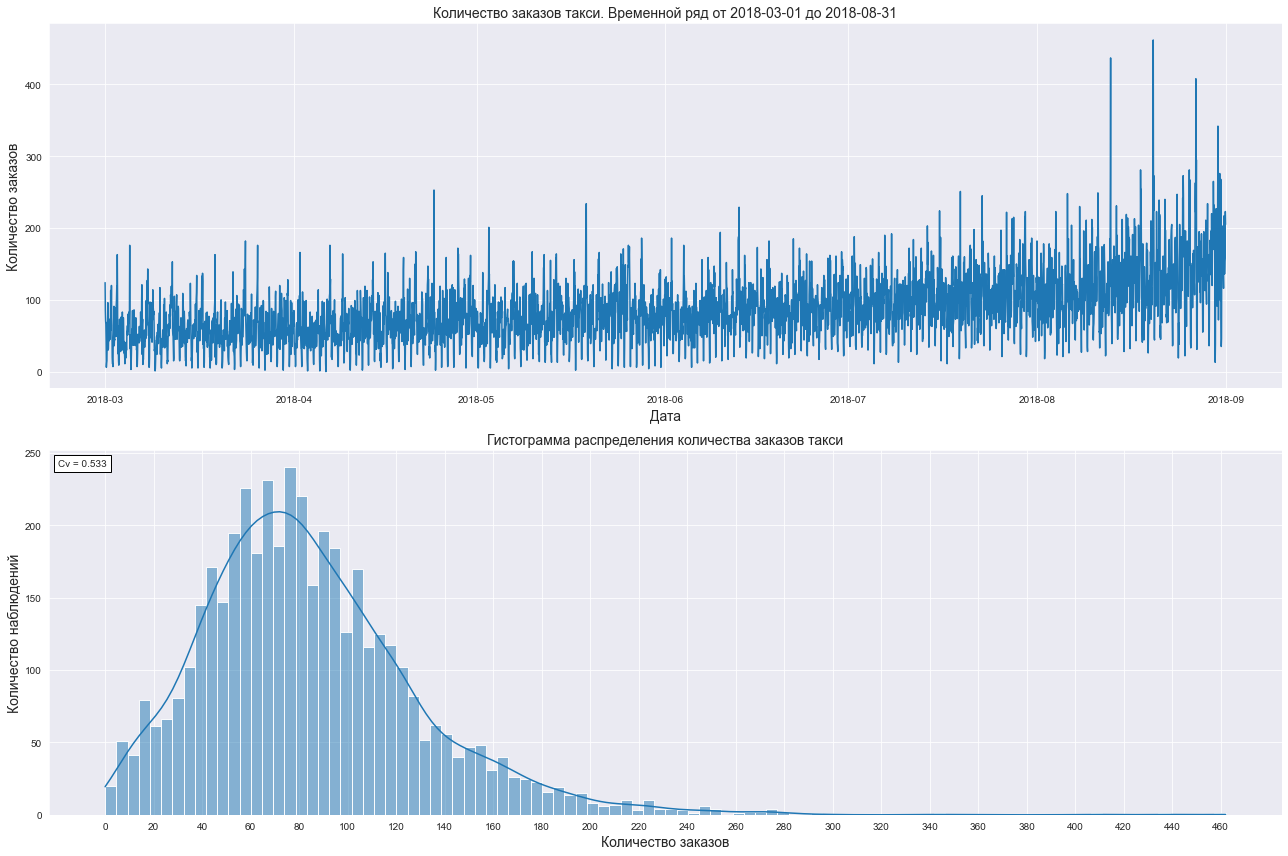

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))

sns.lineplot(x=df.index, y=df['num_orders'], ax=ax[0])
sns.histplot(df['num_orders'], kde=True, bins=100, ax=ax[1])

Mytext = 'Cv = ' + str(round(df['num_orders'].std()/df['num_orders'].mean(), 3))
txt = AnchoredText(Mytext, loc="upper left")
ax[1].add_artist(txt)


ax[0].set_title('Количество заказов такси. Временной ряд от 2018-03-01 до 2018-08-31', fontsize=14)
ax[0].set_xlabel('Дата', fontsize=14)
ax[0].set_ylabel('Количество заказов', fontsize=14)
ax[1].set_title('Гистограмма распределения количества заказов такси', fontsize=14)
ax[1].set_xlabel('Количество заказов', fontsize=14)
ax[1].set_ylabel('Количество наблюдений', fontsize=14)
plt.xticks(range(0, 470, 20))

fig.tight_layout();

In [10]:
decomposed = seasonal_decompose(df)

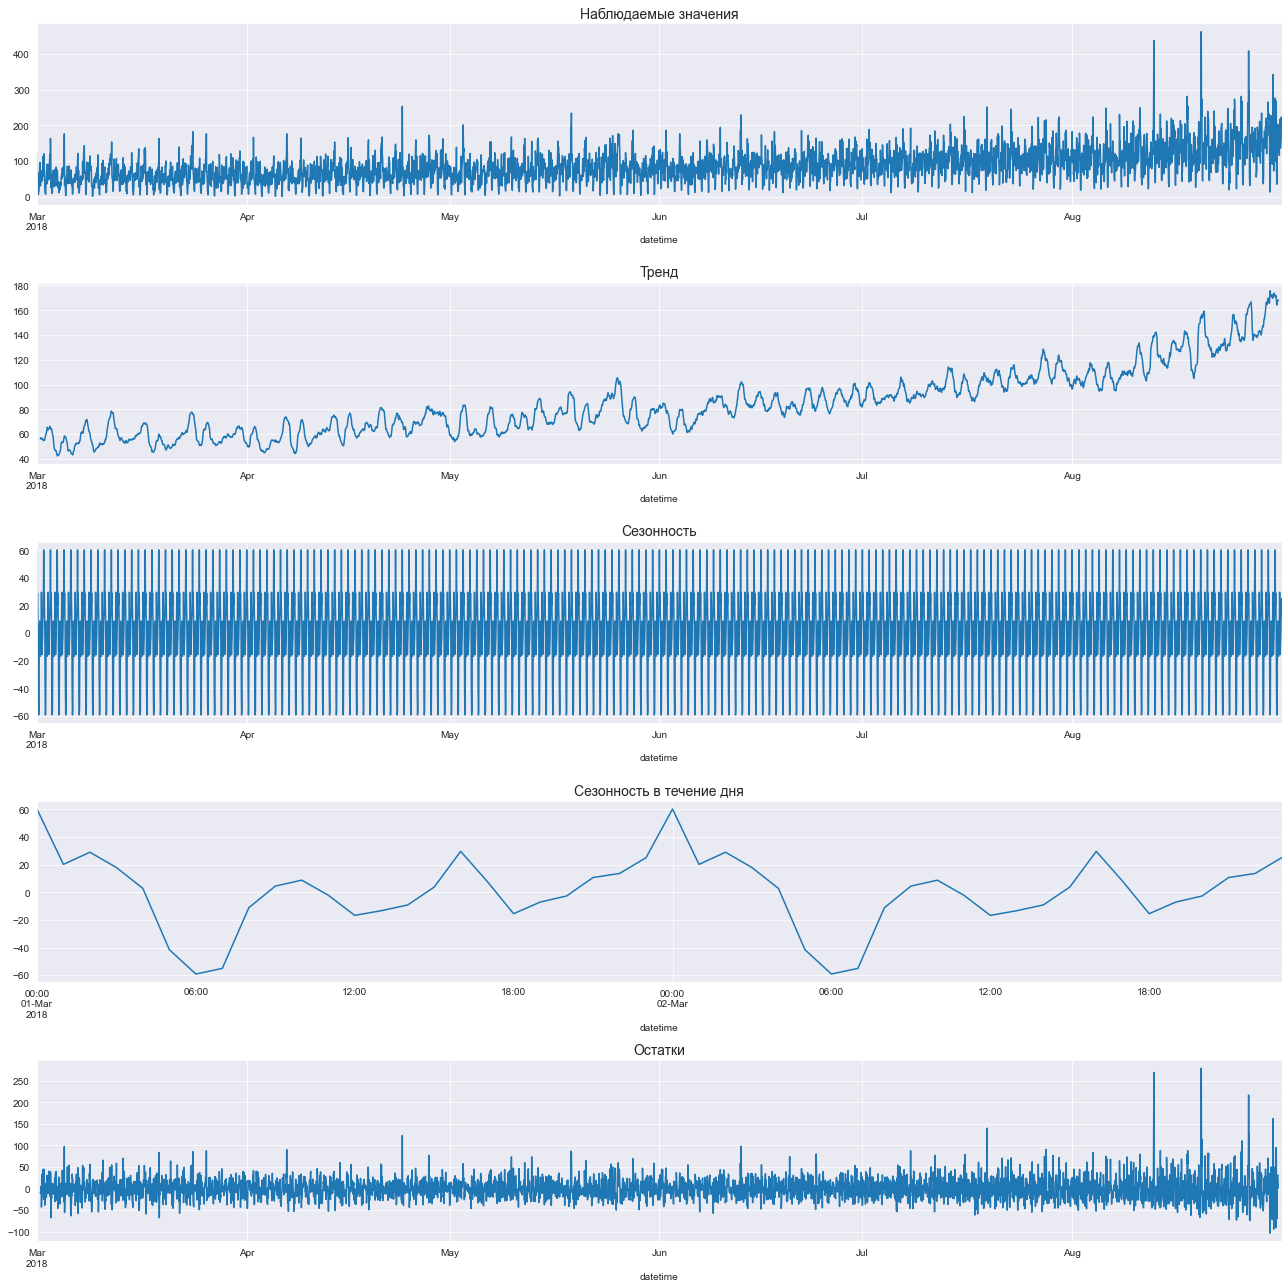

In [11]:
plt.figure(figsize=(18, 18))

plt.subplot(511)
plt.title('Наблюдаемые значения', fontsize=14)
decomposed.observed.plot(ax=plt.gca())

plt.subplot(512)
plt.title('Тренд', fontsize=14)
decomposed.trend.plot(ax=plt.gca())

plt.subplot(513)
plt.title('Сезонность', fontsize=14)
decomposed.seasonal.plot(ax=plt.gca())

plt.subplot(514)
plt.title('Сезонность в течение дня', fontsize=14)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca());

plt.subplot(515)
plt.title('Остатки', fontsize=14)
decomposed.resid.plot(ax=plt.gca())

plt.tight_layout();

Для проверки стационарности временного ряда проведем обобщенный тест Дикки-Фуллера на наличие единичных корней

In [12]:
test_adfuller = adfuller(df)
print(f'Критерий Дики-Фуллера: p={round(test_adfuller[1], 3)}')
if test_adfuller[0] > test_adfuller[4]['1%']:
    print(f'Есть единичные корни, ряд не стационарен при 1%-ном уровне значимости')
else:
    print(f'Единичных корней нет, ряд стационарен при 1%-ном уровне значимости')

Критерий Дики-Фуллера: p=0.029
Есть единичные корни, ряд не стационарен при 1%-ном уровне значимости


**Вывод:**
1. Коэффициент вариации значений количества заказов такси *0.533*. Распределение имеет положительную асимметрию. Среднее значение — *84.4*, медиана — *78*, максимальное значение — *462*.
2. Временной ряд, начиная с середины апреля, имеет выраженный монотонный тренд.
3. Временной ряд имеет ярко выраженною сезонность в течение дня: пиковая нагрузка приходится на *11-12 часов* ночи, минимальная — *5-6 часов* утра. Также можно выделить повышение нагрузки в *15-16 часов* дня.
4. Исходный ряд не является стационарным по критерию Дикки-Фуллера при 1%-ном уровне значимости.

## Моделирование

### Подготовка признаков

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    
    '''Функция создает новые признаки на основе временного ряда и возвращает новый dataframe.
    
    Календарные признаки:
    day - число
    hour - время суток с точностью до  часа
    is_weekend - приходится ли день недели на выходные дни
    
    Отстающие значения:
    количество указывается в max_lag
    
    Скользящее среднее:
    размер окна указывается в rolling_mean_size
    '''
    data = df.copy()
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['is_weekend'] = data.index.dayofweek.isin([5, 6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [14]:
final_df = make_features(df, 80, 3).dropna()
train, test = train_test_split(final_df, shuffle=False, test_size=0.1)

print(f'Начало обучающей выборки: {train.index.min()}, конец обучающей выборки: {train.index.max()}')
print(f'Начало тестовой выборки: {test.index.min()}, конец тестовой выборки: {test.index.max()}')

X_train, X_test = train.drop(['num_orders'], axis=1), test.drop(['num_orders'], axis=1)
y_train, y_test = train['num_orders'], test['num_orders']

Начало обучающей выборки: 2018-03-04 08:00:00, конец обучающей выборки: 2018-08-13 21:00:00
Начало тестовой выборки: 2018-08-13 22:00:00, конец тестовой выборки: 2018-08-31 23:00:00


### Настройка гиперпараметров

С целью проведения сравнения проведем моделирование с использованием следующих алгоритмов регрессии: 
- *LinearRegression*;
- *LGBMRegressor*.

Для настройки гиперпараметров воспользуемся **Optuna** — это среда автоматической настройки гиперпараметров, полностью написанная на Python.

In [15]:
def objective(trial, X, y):
    
    '''Функция objective инкапсулирует весь процесс обучения и выводит точность модели.'''
    
    regressor_name = trial.suggest_categorical('regressor', ['LinearRegression', 'LGBMRegressor'])
    
    if regressor_name == 'LinearRegression':
        
        param_grid = {
        'normalize': trial.suggest_categorical('normalize', [True, False])
        }
            
        model = LinearRegression(**param_grid)
        
    elif regressor_name == 'LGBMRegressor':

        param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [1000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12)
        }
        
        model = LGBMRegressor(random_state=random_seed, **param_grid)
        
    rmse_score = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5, 
                             greater_is_better=False)
    
    tscv = TimeSeriesSplit(n_splits=5)

    return abs(cross_val_score(model, X, y, n_jobs=-1, cv=tscv, scoring=rmse_score).mean())  

In [16]:
%%time
study = optuna.create_study(direction='minimize')
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=100)

[I 2022-02-11 22:39:57,774] A new study created in memory with name: no-name-26146008-7fb9-4037-b08b-da9a1d1a447e
[I 2022-02-11 22:40:04,288] Trial 0 finished with value: 24.88184419052103 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.22175490236140152, 'num_leaves': 1580, 'max_depth': 7}. Best is trial 0 with value: 24.88184419052103.
[I 2022-02-11 22:40:09,303] Trial 1 finished with value: 25.652039354028556 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.33351930183924244, 'num_leaves': 1740, 'max_depth': 7}. Best is trial 0 with value: 24.88184419052103.
[I 2022-02-11 22:40:09,573] Trial 2 finished with value: 24.107259005682238 and parameters: {'regressor': 'LinearRegression', 'normalize': True}. Best is trial 2 with value: 24.107259005682238.
[I 2022-02-11 22:40:14,688] Trial 3 finished with value: 25.79238173819266 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate'

[I 2022-02-11 22:40:52,204] Trial 33 finished with value: 24.241002648298927 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.12395913183560171, 'num_leaves': 360, 'max_depth': 4}. Best is trial 31 with value: 23.641808342923568.
[I 2022-02-11 22:40:53,712] Trial 34 finished with value: 23.86844697502108 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.04011240735176339, 'num_leaves': 20, 'max_depth': 3}. Best is trial 31 with value: 23.641808342923568.
[I 2022-02-11 22:40:57,350] Trial 35 finished with value: 23.627503542401872 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.011825244917181229, 'num_leaves': 880, 'max_depth': 6}. Best is trial 35 with value: 23.627503542401872.
[I 2022-02-11 22:41:00,178] Trial 36 finished with value: 23.87667802201276 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.05637960304009722, 'num_leaves

[I 2022-02-11 22:41:59,788] Trial 63 finished with value: 24.001967683903466 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.05734221302319763, 'num_leaves': 920, 'max_depth': 4}. Best is trial 35 with value: 23.627503542401872.
[I 2022-02-11 22:42:01,178] Trial 64 finished with value: 23.719686765519437 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.027118875787325053, 'num_leaves': 560, 'max_depth': 3}. Best is trial 35 with value: 23.627503542401872.
[I 2022-02-11 22:42:02,576] Trial 65 finished with value: 23.748669007465296 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.02780574018813576, 'num_leaves': 580, 'max_depth': 3}. Best is trial 35 with value: 23.627503542401872.
[I 2022-02-11 22:42:03,887] Trial 66 finished with value: 23.853468392522977 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.05392453275169701, 'num_lea

[I 2022-02-11 22:42:55,864] Trial 93 finished with value: 23.890118228499492 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.03935559284335817, 'num_leaves': 260, 'max_depth': 4}. Best is trial 35 with value: 23.627503542401872.
[I 2022-02-11 22:42:57,228] Trial 94 finished with value: 23.691163284582444 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.020868538454165482, 'num_leaves': 860, 'max_depth': 3}. Best is trial 35 with value: 23.627503542401872.
[I 2022-02-11 22:43:00,488] Trial 95 finished with value: 23.731436196362914 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.020414604569904845, 'num_leaves': 1120, 'max_depth': 6}. Best is trial 35 with value: 23.627503542401872.
[I 2022-02-11 22:43:02,154] Trial 96 finished with value: 25.737405766678336 and parameters: {'regressor': 'LGBMRegressor', 'n_estimators': 1000, 'learning_rate': 0.33431643229304486, 'num_l

Wall time: 3min 9s


In [17]:
print('Лучшая модель:')
for key, value in study.best_params.items():
    print(f'\t\t{key}: {value}')

Лучшая модель:
		regressor: LGBMRegressor
		n_estimators: 1000
		learning_rate: 0.011825244917181229
		num_leaves: 880
		max_depth: 6


### Тестирование

In [23]:
model = LGBMRegressor(random_state=random_seed, 
                      n_estimators=study.best_params['n_estimators'], 
                      learning_rate=study.best_params['learning_rate'], 
                      num_leaves=study.best_params['num_leaves'], 
                      max_depth=study.best_params['max_depth'])

In [24]:
start_learning = time.time()
model.fit(X_train, y_train)
end_learning = time.time()
duration_learning = end_learning - start_learning
    
start_predictions = time.time()    
y_pred = model.predict(X_test)
test_rmse_score = mean_squared_error(y_test, y_pred)**0.5
end_predictions = time.time()
duration_prediction = end_predictions - start_predictions

In [25]:
results = pd.DataFrame({'Regressor' : ['LGBMRegressor'], 
                        'Train RMSE score' : [study.best_value], 
                        'Test RMSE score' : [test_rmse_score], 
                        'Learning time, s' : [duration_learning], 
                        'Prediction time, s' : [duration_prediction]})
results

,Regressor,Train RMSE score,Test RMSE score,"Learning time, s","Prediction time, s"
0,LGBMRegressor,23.627504,38.653337,1.011365,0.001634


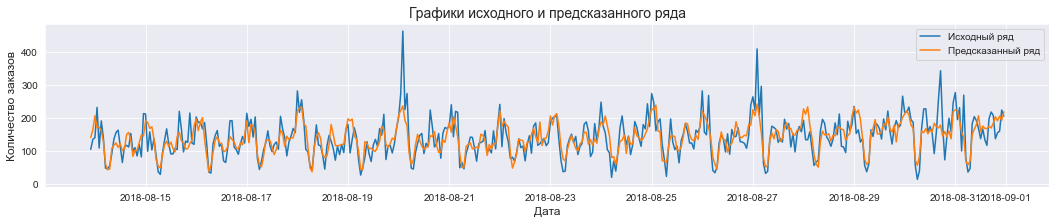

In [49]:
plt.figure(figsize=(18, 3))
sns.lineplot(x=y_test.index, y=y_test)
sns.lineplot(x=y_test.index, y=y_pred)

plt.legend(['Исходный ряд', 'Предсказанный ряд'])
plt.title('Графики исходного и предсказанного ряда', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12);

**Вывод:**
1. Лучшие результаты на тестовой выборке с использованием метрики RMSE показала модель *LGBMRegressor* с результатом 38.65.
2. Время подбора гиперпараметров — 3 мин. 9 сек.
3. Время обучения — 1.01 сек.
4. Время предсказания — 0.002 сек.

## Общий вывод

Перед нами стояла задача построить модель для прогнозирования временного ряда, которая предскажет количество заказов такси на следующий час по историческим данным таксопарка о заказах такси в аэропортах. В дальнейшем модель будет использоваться, чтобы привлекать больше водителей в период пиковой нагрузки.

С целью исключения факторов снижающих качество данных была изучена вариативность значений количества заказов, тренд временного ряда, сезонность временного ряда и стационарность временного ряда, проведено ресемплирование. Создание новых признаков основывалось на том, что тренд и сезонность привязаны к конкретной дате, поэтому были добавлены календарные признаки. Также были расчитаны и добавлены разности временного ряда и скользящее среднее. Все это в итоге позволило подойти к анализу и получению ответа на целевой вопрос.

Для достижения поставленной цели было изучено и смоделировано 2 алгоритма регрессии:

- LinearRegression;
- LGBMRegressor.

В качестве метрики оценки производительности использовалась метрика *RMSE*.

В результате проведенного исследования лучшие результаты RMSE на тестовой выборке показала модель LGBMRegressor с результатом *38.65*.

Ниже представлены таблица и график, несущие информацию о важности признаков, полученную с использованием лучшей модели.

In [21]:
feature_importances_df = pd.DataFrame(data=model.feature_importances_,
                                      index=X_train.columns,
                                      columns=['feature_importance'])

feature_importances_df.sort_values('feature_importance', ascending=False).head(10).style.background_gradient('coolwarm')

,feature_importance
lag_72,868
lag_48,822
lag_24,718
rolling_mean,594
lag_47,571
lag_1,561
lag_12,521
lag_7,484
lag_11,464
hour,430


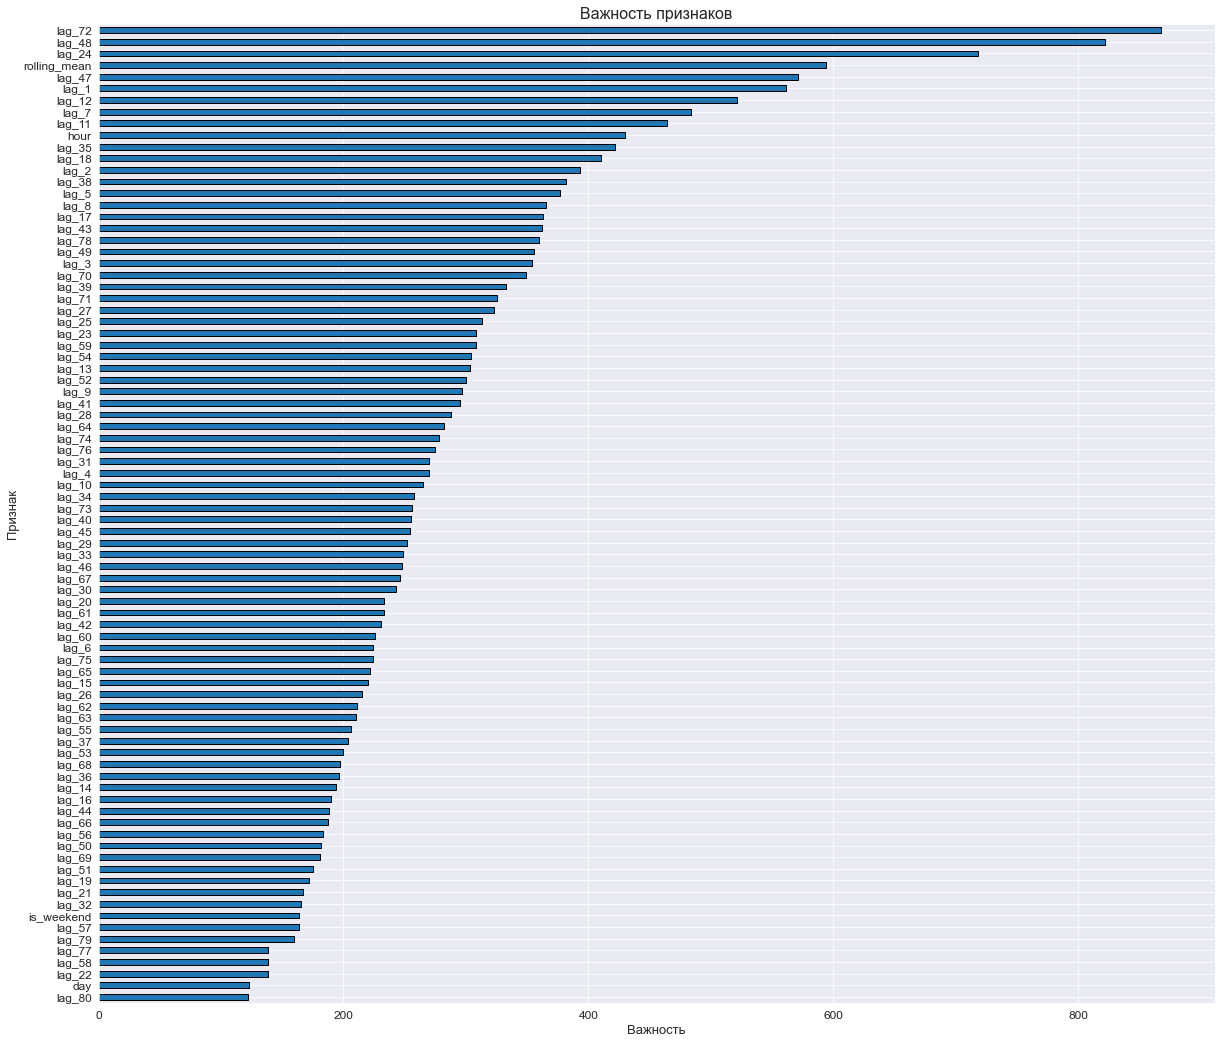

In [22]:
ax = feature_importances_df.sort_values(by='feature_importance').plot(kind='barh', 
                                                                      figsize=(20, 18), 
                                                                      ec='black', 
                                                                      legend=False, 
                                                                      fontsize=12)

ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность', fontsize=13)
ax.set_ylabel('Признак', fontsize=13);